In [254]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [255]:
FIRST_SIZE = 2
LAST_SIZE = 200
STEP_SIZE = 10

COUNT_TRIES = 10

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.0001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [256]:
(LAST_SIZE - FIRST_SIZE + 1), (LAST_SIZE - FIRST_SIZE + 1) / STEP_SIZE, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1)

(199, 19.9, 20)

In [257]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time",
        "value_min_rel",
        "value_min_rel_time"
    ],
    index=range(1, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [258]:
def calc(A: np.matrix, b: np.matrix) -> np.matrix:
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [259]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1)
    # print("Начальное приближение:", b_k, sep="\n")

    alpha_old = None

    # for _ in range(num_iterations):
    while True:
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

## Стандартная версия

In [260]:
def inverse_power_def(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    try:
        inv_A = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None
    # print("Обратная матрица:",inv_A, sep="\n")
    res = power_iteration(
        A=inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )
    return res[0], 1 / res[1]

In [261]:
A: np.matrix = np.matrix("1 3 -2 0;"
                         "1 1 4 7;"
                         "4 7 11 23;"
                         "52 66 2 0")  # -0.65
calc(A, inverse_power_def(A))

## Модификация Релэя

In [262]:
def inverse_power_rel(A, epsilon = DEF_EPS, mu = None, b_k = None):
  if b_k is None:
      b_k = np.random.rand(A.shape[1], 1) # Попробовать близкий к настоящему собственный вектор
      
  if mu is None:
    mu = np.random.randint(1, 1000) / 100
#   print("R:\n", mu, " ", b_k, "\n")
  
  b_k = b_k / np.linalg.norm(b_k)
  try:
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
  except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None, None
  # print(y)
  np.random.randint
  # print(x)
  lambda_ = float(np.dot(y.T, b_k))
  # print(lambda_, lambda_ * x)
  mu = mu + 1 / lambda_
  err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  while err > epsilon:
    b_k = y / np.linalg.norm(y)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    mu = mu + 1 / lambda_
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  return b_k, float(mu)

In [263]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# Сильно зависит от начального приближения
# Не вижу в ней смысла
inverse_power_rel(A)[1]
# calc(A, inverse_power_rel(A)[0])

-1.000000000005799

# Вычисление

In [264]:
def output(
    A: np.matrix,
    texts: list[str],
    funcs: list,
    num_iterrations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    mu: float = None,
) -> tuple[np.matrix, list[float | None]]:

    eigs = np.linalg.eigvals(A)
    # print(type(eigs[0]))
    if any(isinstance(eig, np.complex128) for eig in eigs):
        print(eigs)

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)
    # print(

    #     "Собственные значения матрицы A",

    #     f"Максимальное: {abs_v_max}",
    #     f"Минимальное: {abs_v_min}",
    #     sep="\n",
    # )

    # print("========")

    mass_eval = []

    for text, f in zip(texts, funcs):
        start_time = time()
        # print(text)
        if f.__name__ != inverse_power_rel.__name__:
            evec, eval = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # evec = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # eval = calc(A, evec)
        else:
            evec, eval = f(A=A, b_k=b_k, mu=mu)
        stop_time = time()
        # print("========")
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)

    # print(text_1)

    # first_evec = f_1(A=A, num_iterations=num_iterrations, b_k=b_k)

    # first_eval = calc(A, first_evec)
    # print("========")

    # print(text_2)

    # if f_2.__name__ != inverse_power_rel.__name__:

    #     second_evec = f_2(A=A, num_iterations=num_iterrations, b_k=b_k)

    #     second_eval = calc(A, second_evec)

    # else:

    #     second_evec, second_eval = f_2(A=A, b_k=b_k, mu=mu)
    # print("========")

    # print(

    #     "Собственные векторы:",

    #     f"{text_1}:",
    #     first_evec,

    #     f"{text_2}:",

    #     second_evec,

    #     sep="\n",
    # )
    # print(

    #     "Собственные значения:",

    #     f"{text_1}: {first_eval}",

    #     f"{text_2}: {second_eval}",

    #     sep="\n",
    # )

    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

In [265]:
def generate_non_singular(n):
    while True:
        matrix = np.random.rand(n, n)
        if np.linalg.det(matrix) != 0:
            return matrix

In [266]:
import numpy as np
texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Релэя)"]
funcs = [power_iteration, inverse_power_def, inverse_power_rel]
# texts = ["Прямые итерации", "Обратные итерации (обычные)"]
# funcs = [power_iteration, inverse_power_def]
mass = []

for i in range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        matr = matr @ matr.T
        # TODO: Комплексные корни???
        # В вычислениях проверять на комплексные корни
        df.iloc[((i - FIRST_SIZE) // STEP_SIZE) * COUNT_TRIES + j] = output(matr, texts, funcs)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])
df["delta_min_rel"] = abs(df["true_value_min"] - df["value_min_rel"])

df

Current size:2
1
2
3
4
5
6
7
8
9
10

Current size:12
1
2
3
4
5
6
7
8
9
10

Current size:22
1
2
3
4
5
6
7
8
9
10

Current size:32
1
2
3
4
5
6
7
8
9
10

Current size:42
1
2
3
4
5
6
7
8
9
10

Current size:52
1
2
3
4
5
6
7
8
9
10

Current size:62
1
2
3
4
5
6
7
8
9
10

Current size:72
1
2
3
4
5
6
7
8
9
10

Current size:82
1
2
3
4
5
6
7
8
9
10

Current size:92
1
2
3
4
5
6
7
8
9
10

Current size:102
1
2
3
4
5
6
7
8
9
10

Current size:112
1
2
3
4
5
6
7
8
9
10

Current size:122
1
2
3
4
5
6
7
8
9
10

Current size:132
1
2
3
4
5
6
7
8
9
10

Current size:142
1
2
3
4
5
6
7
8
9
10

Current size:152
1
2
3
4
5
6
7
8
9
10

Current size:162
1
2
3
4
5
6
7
8
9
10

Current size:172
1
2
3
4
5
6
7
8
9
10

Current size:182
1
2
3
4
5
6
7
8
9
10

Current size:192
1
2
3
4
5
6
7
8
9
10



,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
1,2,0.94042,0.000531,0.94042,0.0,0.000531,0.0,0.000531,0.001,0.0,0.0,0.0
2,2,1.303442,0.349593,1.303439,0.0,0.349593,0.001003,1.303442,0.0,0.000003,0.000001,0.953849
3,2,0.479086,0.037633,0.479086,0.0,0.037633,0.0,0.037633,0.000998,0.0,0.0,0.0
4,2,1.749567,0.0004,1.749567,0.0,0.0004,0.0,1.749567,0.0,0.0,0.0,1.749167
5,2,1.324552,0.002281,1.324552,0.0,0.002281,0.001,1.324552,0.0,0.0,0.0,1.322272
...,...,...,...,...,...,...,...,...,...,...,...,...
196,192,9217.941035,0.000081,9217.941035,0.0,0.000081,0.004005,4.831184,0.001998,0.0,0.0,4.831102
197,192,9156.882934,0.000859,9156.882934,0.0,0.000859,0.003,3.589234,0.00251,0.0,0.0,3.588375
198,192,9218.606381,0.000036,9218.606381,0.0,0.000036,0.003005,3.952054,0.001999,0.0,0.0,3.952018
199,192,9257.119557,0.00014,9257.119557,0.0,0.00014,0.008517,0.660366,0.002503,0.0,0.0,0.660226


In [267]:
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
1,2,0.94042,0.000531,0.94042,0.0,0.000531,0.0,0.000531,0.001,0.0,0.0,0.0
2,2,1.303442,0.349593,1.303439,0.0,0.349593,0.001003,1.303442,0.0,0.000003,0.000001,0.953849
3,2,0.479086,0.037633,0.479086,0.0,0.037633,0.0,0.037633,0.000998,0.0,0.0,0.0
4,2,1.749567,0.0004,1.749567,0.0,0.0004,0.0,1.749567,0.0,0.0,0.0,1.749167
5,2,1.324552,0.002281,1.324552,0.0,0.002281,0.001,1.324552,0.0,0.0,0.0,1.322272
...,...,...,...,...,...,...,...,...,...,...,...,...
196,192,9217.941035,0.000081,9217.941035,0.0,0.000081,0.004005,4.831184,0.001998,0.0,0.0,4.831102
197,192,9156.882934,0.000859,9156.882934,0.0,0.000859,0.003,3.589234,0.00251,0.0,0.0,3.588375
198,192,9218.606381,0.000036,9218.606381,0.0,0.000036,0.003005,3.952054,0.001999,0.0,0.0,3.952018
199,192,9257.119557,0.00014,9257.119557,0.0,0.00014,0.008517,0.660366,0.002503,0.0,0.0,0.660226


In [268]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
2,2,1.303442,0.349593,1.303439,0.0,0.349593,0.001003,1.303442,0.0,0.000003,0.000001,0.953849
8,2,1.015368,0.178238,1.015367,0.0,0.178238,0.0,0.178238,0.001006,0.000001,0.0,0.0
20,12,36.256453,0.01572,36.256452,0.0,0.01572,0.001508,2.067082,0.0,0.0,0.0,2.051362
15,12,35.682939,0.002526,35.682939,0.0,0.002526,0.0,1.043362,0.0,0.0,0.0,1.040836
19,12,45.768019,0.001141,45.768019,0.0,0.001141,0.0,0.838382,0.0,0.0,0.0,0.837241
13,12,37.659103,0.00143,37.659103,0.0,0.00143,0.0,0.363408,0.000998,0.0,0.0,0.361978
21,22,127.348508,0.000206,127.348508,0.0,0.000206,0.0,5.022257,0.0,0.0,0.0,5.022051
16,12,35.032785,0.000673,35.032785,0.0,0.000673,0.0,3.195416,0.0,0.0,0.0,3.194743
12,12,34.892628,0.000089,34.892628,0.0,0.000089,0.0,2.203437,0.001004,0.0,0.0,2.203348
14,12,36.510609,0.001003,36.510609,0.0,0.001003,0.0,1.931428,0.001002,0.0,0.0,1.930425


In [269]:
df.sort_values("delta_min_def", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
2,2,1.303442,0.349593,1.303439,0.0,0.349593,0.001003,1.303442,0.0,0.000003,0.000001,0.953849
17,12,34.061784,0.038957,34.061784,0.0,0.038957,0.0,0.889034,0.0,0.0,0.0,0.850077
36,32,264.899842,0.017889,264.899842,0.001,0.017889,0.0,2.683663,0.001,0.0,0.0,2.665774
20,12,36.256453,0.01572,36.256452,0.0,0.01572,0.001508,2.067082,0.0,0.0,0.0,2.051362
65,62,992.259944,0.010365,992.259944,0.0,0.010365,0.00101,7.126672,0.0,0.0,0.0,7.116308
22,22,117.984223,0.017425,117.984223,0.0,0.017425,0.0,2.572575,0.0,0.0,0.0,2.55515
8,2,1.015368,0.178238,1.015367,0.0,0.178238,0.0,0.178238,0.001006,0.000001,0.0,0.0
32,32,261.753499,0.006147,261.753499,0.0,0.006147,0.0,4.049975,0.001006,0.0,0.0,4.043828
177,172,7433.143447,0.000873,7433.143447,0.0,0.000873,0.004518,1.657043,0.001997,0.0,0.0,1.65617
27,22,126.542943,0.016171,126.542943,0.0,0.016171,0.0,0.192348,0.000999,0.0,0.0,0.176176


In [270]:
df.sort_values("delta_min_rel", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
129,122,3756.845539,0.000488,3756.845539,0.0,0.000488,0.001505,9.95147,0.002011,0.0,0.0,9.950982
189,182,8406.112389,0.000426,8406.112389,0.0,0.000426,0.009517,9.944653,0.000999,0.0,0.0,9.944228
148,142,5097.876151,0.000073,5097.876151,0.001001,0.000073,0.03056,9.863894,0.002016,0.0,0.0,9.863821
143,142,5096.332861,0.000531,5096.332861,0.0,0.000531,0.002005,9.861862,0.001003,0.0,0.0,9.861331
190,182,8330.704873,0.000357,8330.704873,0.0,0.000357,0.003506,9.788188,0.002006,0.0,0.0,9.787831
102,102,2585.745577,0.002715,2585.745577,0.0,0.002715,0.001999,9.361513,0.001,0.0,0.0,9.358798
78,72,1305.176428,0.001006,1305.176428,0.0,0.001006,0.0,9.247918,0.0,0.0,0.0,9.246913
121,122,3738.074068,0.000017,3738.074068,0.0,0.000017,0.002005,9.113816,0.001005,0.0,0.0,9.113799
69,62,936.969771,0.000009,936.969771,0.0,0.000009,0.0,9.098376,0.001008,0.0,0.0,9.098367
131,132,4355.752281,0.00028,4355.752281,0.0,0.00028,0.002001,9.058625,0.001002,0.0,0.0,9.058345


# Графическая часть

In [271]:
import matplotlib.pyplot as plt

In [272]:
res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def", "delta_min_rel"]]
figsize = (18, 6)
b_k = range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE * 4)
x_lt = np.linspace(FIRST_SIZE, LAST_SIZE)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
1,2,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.001003,0.000003,0.000001,0.953849
3,2,0.0,0.0,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0,1.749167
5,2,0.0,0.001,0.0,0.0,1.322272
...,...,...,...,...,...,...
196,192,0.0,0.004005,0.0,0.0,4.831102
197,192,0.0,0.003,0.0,0.0,3.588375
198,192,0.0,0.003005,0.0,0.0,3.952018
199,192,0.0,0.008517,0.0,0.0,0.660226


In [273]:
max(res_df["delta_min_def"])

np.float64(5.012957591810085e-07)

In [274]:
max(res_df["delta_min_rel"])

np.float64(9.950982149519616)

In [275]:
mean_df = res_df.groupby("size").mean()
mean_df

,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
size,,,,,
2,0.0,0.0002,0.0,0.0,0.813896
12,0.0002,0.000151,0.0,0.0,1.840637
22,0.000101,0.0001,0.0,0.0,3.4295
32,0.0001,0.000101,0.0,0.0,3.709847
42,0.0002,0.000251,0.0,0.0,4.863763
52,0.0001,0.000552,0.0,0.0,6.136657
62,0.0002,0.000302,0.0,0.0,6.434354
72,0.0001,0.0001,0.0,0.0,4.104509
82,0.0,0.0002,0.0,0.0,4.113898


In [276]:
max(mean_df['delta_min_def']), max(mean_df['delta_min_rel'])

(5.0579651219840425e-08, 7.258874885967981)

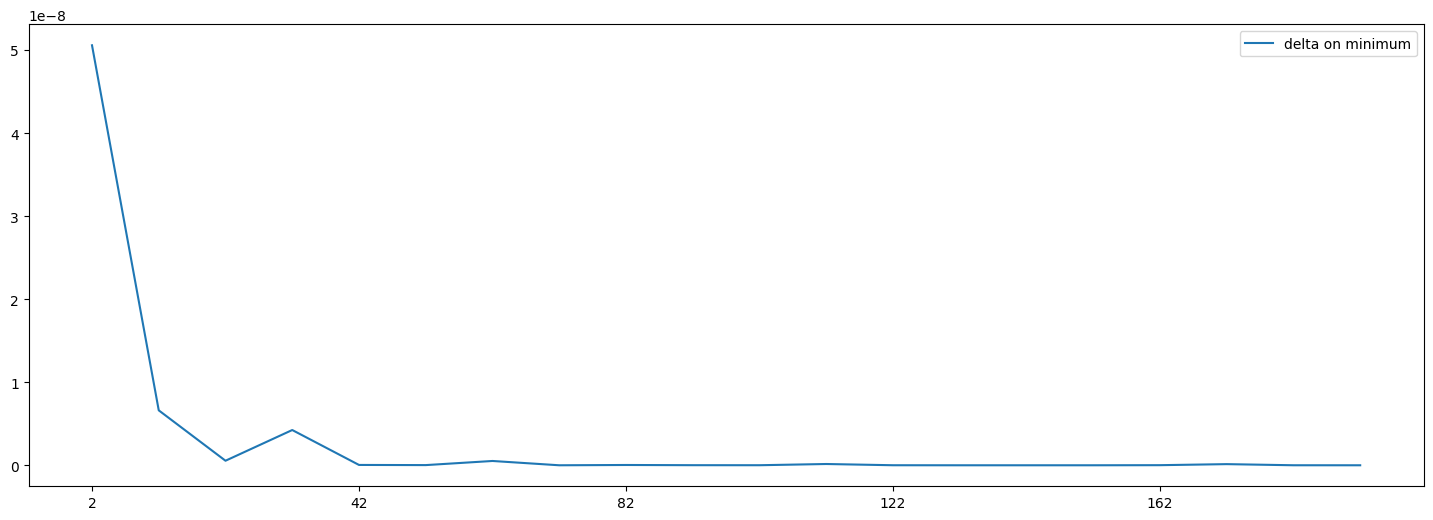

In [277]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)

plt.plot(mean_df["delta_min_def"])
plt.legend(["delta on minimum"])
# mean_res.plot()

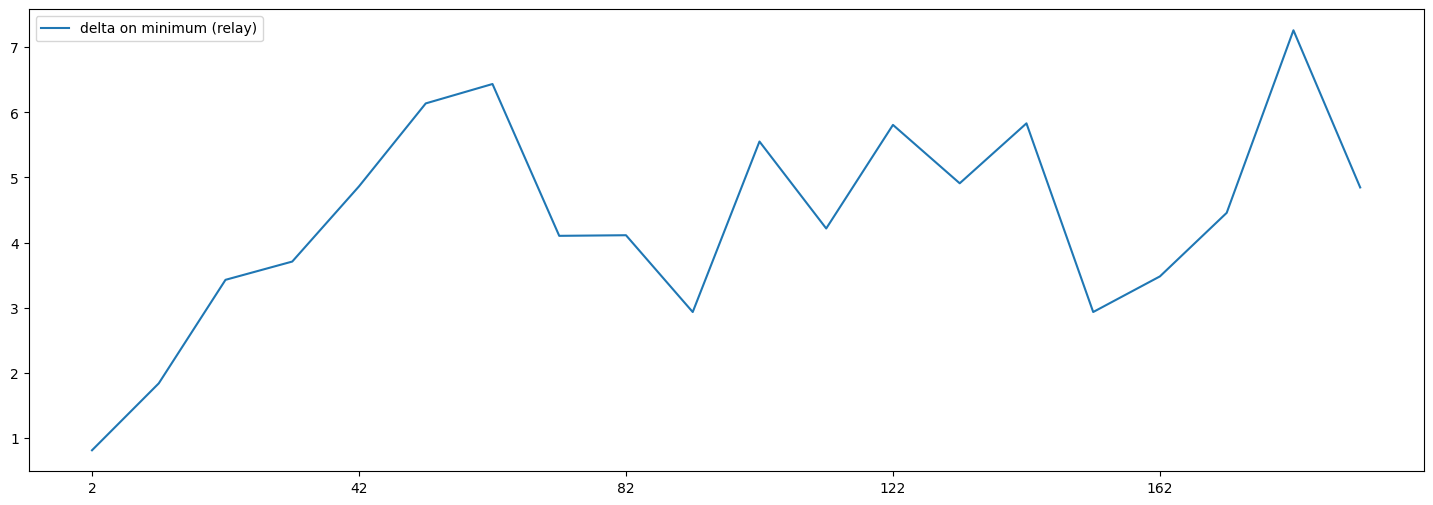

In [278]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)

plt.plot(mean_df["delta_min_rel"])
plt.legend(["delta on minimum (relay)"])
# mean_res.plot()

4.281382209092577e-07


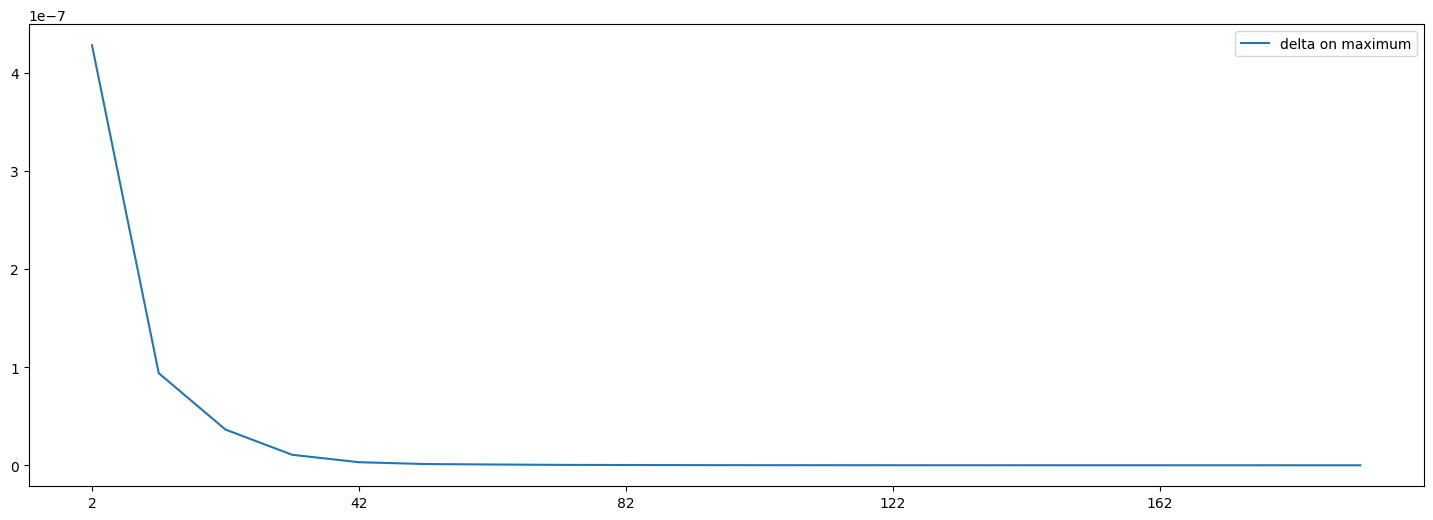

In [279]:
print(max(mean_df['delta_max']))
plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)
plt.plot(mean_df["delta_max"])
plt.legend(["delta on maximum"])

<Figure size 1800x600 with 0 Axes>

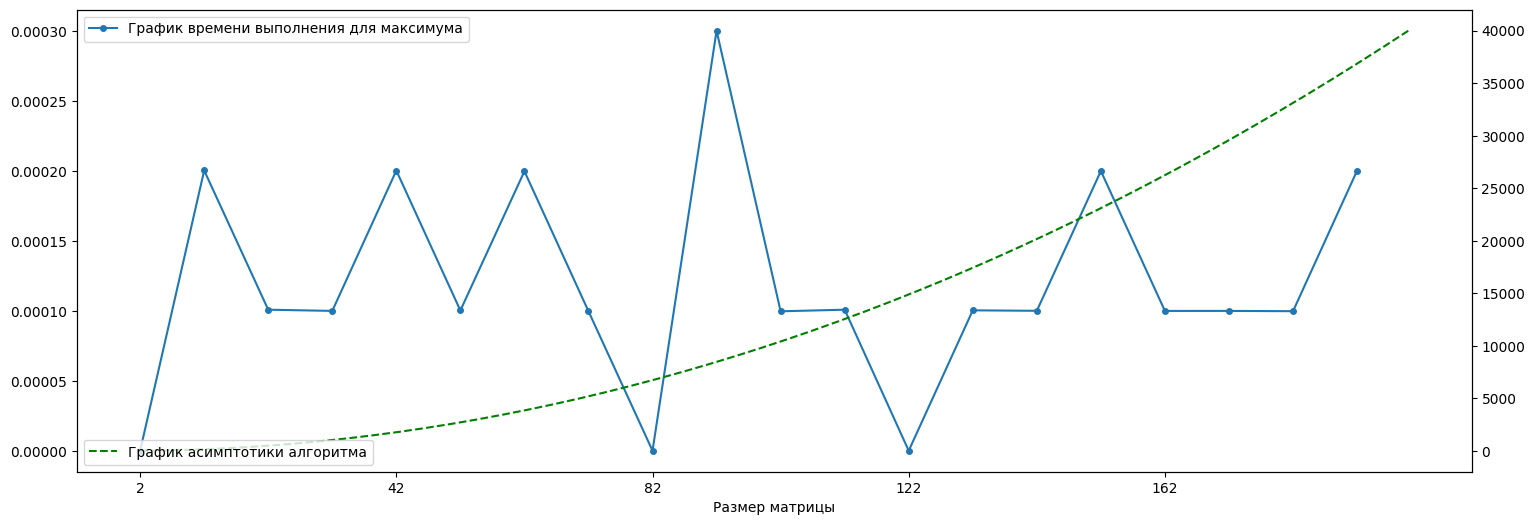

In [280]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_df['value_max_time'],  marker='o',  markersize=4, label='График времени выполнения для максимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 2, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()
# plt.xticks(ticks=x)
# plt.legend(["time for calculation of maximum"])


<Figure size 1800x600 with 0 Axes>

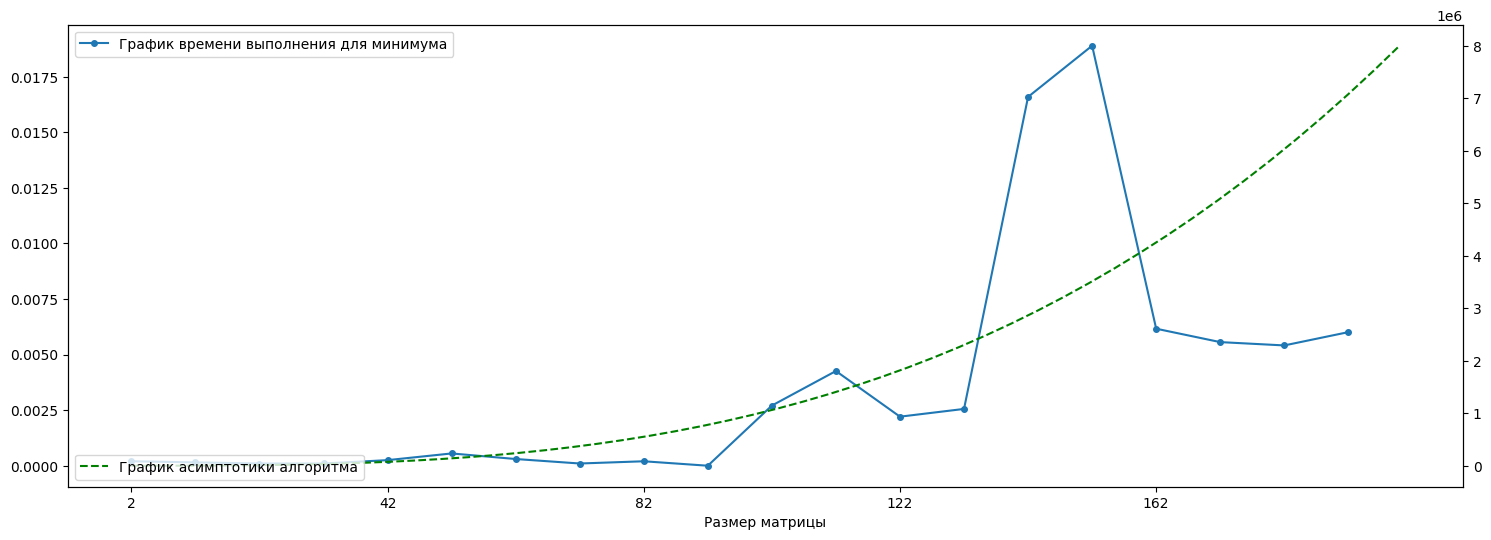

In [281]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_df['value_min_def_time'],  marker='o',  markersize=4, label='График времени выполнения для минимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 3, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
# plt.plot(x=x, y=x**2)
# plt.legend(["time for calculation of minimum"])
plt.show()

<Figure size 1800x600 with 0 Axes>

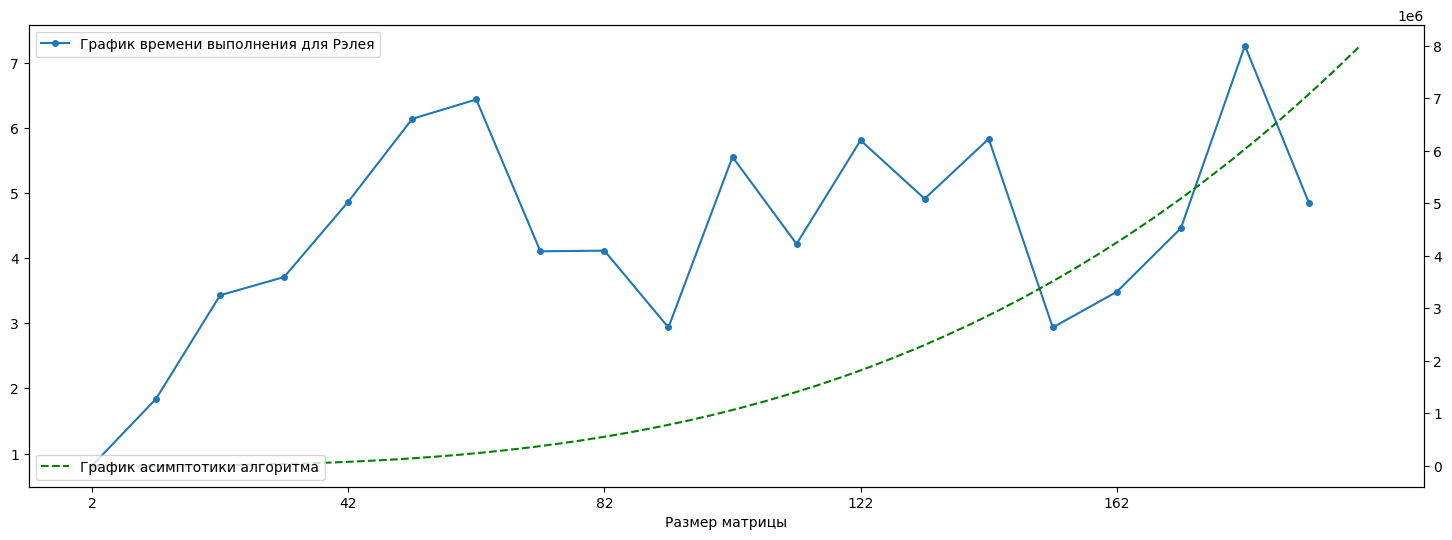

In [282]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_df['delta_min_rel'],  marker='o',  markersize=4, label='График времени выполнения для Рэлея')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 3, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
# plt.plot(x=x, y=x**2)
# plt.legend(["time for calculation of minimum"])
plt.show()

In [283]:
# df.to_csv("data/df.csv")
# mean_df.to_csv("data/mean_df.csv")
# res_df.to_csv("data/res_df.csv")